In [24]:
from mnist import get_MNIST
import torch
import torch.nn as nn
from torch.utils import data
import torch.nn.functional as F

train_dataset, test_dataset = get_MNIST(test=True)

In [25]:
class MNIST_Classifier(nn.Module):
    def __init__(self):
        super(MNIST_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.conv2 = nn.Conv2d(8, 8, 3)
        self.fc1 = nn.Linear(8*24*24, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 8*24*24)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [26]:
classifier = MNIST_Classifier()
loader = data.DataLoader(train_dataset, batch_size=256, shuffle=True)
optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss(reduction='mean')

# classifier.train()
# for epoch in range(20):
#     epoch_loss = 0
#     for i, (images, labels) in enumerate(loader):
#         output = classifier(images)
#         loss = loss_fn(output, labels)
#         epoch_loss += loss.item()
#         loss.backward()
#         optimizer.step()
#         optimizer.zero_grad()
#     print(f'Epoch {epoch}: {epoch_loss / len(loader)}')

classifier.load_state_dict(torch.load('data/mnist_classifier/model.pth'))

<All keys matched successfully>

In [27]:
test_loader = data.DataLoader(test_dataset, batch_size=256, shuffle=False)
uncertainty_fn = nn.CrossEntropyLoss(reduction='sum')

classifier.eval()
uncertainty = 0
correct = 0
total = 0
for i, (images, labels) in enumerate(test_loader):
    output = classifier(images)
    predicted = torch.argmax(output, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    uncertainty += uncertainty_fn(output, labels).item()

print(f'Accuracy: {correct / total}')
print(f'Uncertainty: {uncertainty / total}')

Accuracy: 0.986
Uncertainty: 0.056167109027169315


In [30]:
import pickle
import io
from mnist import merge_datasets

class CPU_Unpickler(pickle.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

all_accuracies_mle = {}
all_uncertainties_mle = {}

for coreset_size in [0, 50, 200, 500]:
    accuracies = []
    uncertainties = []
    for i in range(10):
        with open(f'./data/mle_{coreset_size}/{i}/sampled_dataset.pkl', 'rb') as f:
            dataset1 = CPU_Unpickler(f).load()
        with open(f'./data/mle_{coreset_size}/sampled_datasets/{i}.pkl', 'rb') as f:
            dataset2 = CPU_Unpickler(f).load()

        dataset = merge_datasets([dataset1, dataset2])
        print(i, len(dataset))
        out = classifier(dataset.data)
        predicted = torch.argmax(out, 1)
        correct = (predicted == dataset.targets).sum().item()
        accuracies.append(correct / len(dataset))
        uncertainty = uncertainty_fn(out, dataset.targets).item()
        uncertainties.append(uncertainty / len(dataset))

    all_accuracies_mle[coreset_size] = accuracies
    all_uncertainties_mle[coreset_size] = uncertainties


0 600
1 600
2 594
3 600
4 600
5 594
6 588
7 600
8 594
9 600
0 600
1 600
2 594
3 600
4 600
5 594
6 588
7 600
8 594
9 600
0 600
1 600
2 594
3 600
4 600
5 594
6 588
7 600
8 594
9 600
0 600
1 600
2 594
3 600
4 600
5 594
6 588
7 600
8 594
9 600


In [31]:
all_accuracies_vcl = {}
all_uncertainties_vcl = {}

for coreset_size in [0, 50, 200, 500]:
    accuracies = []
    uncertainties = []
    for i in range(10):
        with open(f'./data/vcl_{coreset_size}/{i}/sampled_dataset.pkl', 'rb') as f:
            dataset1 = CPU_Unpickler(f).load()
        with open(f'./data/vcl_{coreset_size}/sampled_datasets/{i}.pkl', 'rb') as f:
            dataset2 = CPU_Unpickler(f).load()

        dataset = merge_datasets([dataset1, dataset2])
        print(i, len(dataset))
        out = classifier(dataset.data)
        predicted = torch.argmax(out, 1)
        correct = (predicted == dataset.targets).sum().item()
        accuracies.append(correct / len(dataset))
        uncertainty = uncertainty_fn(out, dataset.targets).item()
        uncertainties.append(uncertainty / len(dataset))

    all_accuracies_vcl[coreset_size] = accuracies
    all_uncertainties_vcl[coreset_size] = uncertainties

0 600
1 600
2 594
3 600
4 600
5 594
6 588
7 600
8 594
9 600
0 600
1 600
2 594
3 600
4 600
5 594
6 588
7 600
8 594
9 600
0 600
1 600
2 594
3 600
4 600
5 594
6 588
7 600
8 594
9 600
0 600
1 600
2 594
3 600
4 600
5 594
6 588
7 600
8 594
9 600


In [33]:
all_uncertainties_mle

{0: [0.0003333825866381327,
  4.0034375,
  6.0455322265625,
  15.074031575520833,
  7.430462239583333,
  13.019486038773149,
  8.70964122953869,
  11.409599609375,
  7.065430509522306,
  6.543514404296875],
 50: [0.04144978205362956,
  0.01543632984161377,
  0.06429739672728259,
  0.2990972391764323,
  1.6978920491536458,
  0.4637222546921033,
  0.7335879786484907,
  1.8058723958333334,
  1.5005092428188131,
  2.5666668701171873],
 200: [4.325477639213204e-06,
  0.0035348820686340334,
  0.0020968033007098368,
  3.497336680690448e-05,
  0.01934468905131022,
  0.0042354667226874865,
  0.0022358194905884414,
  0.0013739984234174092,
  0.05362383524576823,
  0.0015570955475171407],
 500: [5.679984266559283e-06,
  0.00010016996413469314,
  1.3128500776710334e-05,
  0.000482139786084493,
  7.60543408493201e-05,
  0.0005216361195952804,
  1.434518695891309e-05,
  0.0010954697926839193,
  3.229180720920113e-05,
  0.009304649829864502]}

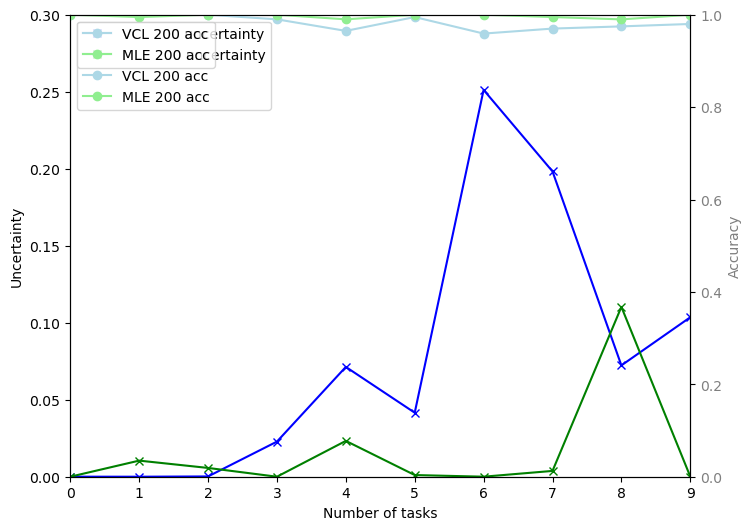

In [10]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
coreset = 200

lns1 = ax1.plot(list(range(10)), all_uncertainties_vcl[coreset], '-x', label=f'VCL {coreset} uncertainty', color='blue')
lns2 = ax1.plot(list(range(10)), all_uncertainties_mle[coreset], '-x', label=f'MLE {coreset} uncertainty', color='green')
ax1.set_xlim(0, 9)
ax1.set_ylim(0, .3)
ax1.set_xlabel('Number of tasks')
ax1.set_ylabel('Uncertainty')

color = 'tab:grey'
ax2 = ax1.twinx()
lns3 = ax2.plot(list(range(10)), all_accuracies_vcl[coreset], '-o', label=f'VCL {coreset} acc', color='lightblue')
lns4 = ax2.plot(list(range(10)), all_accuracies_mle[coreset], '-o', label=f'MLE {coreset} acc', color='lightgreen')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Accuracy', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.legend()

lns = lns1+lns2+lns3+lns4
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)


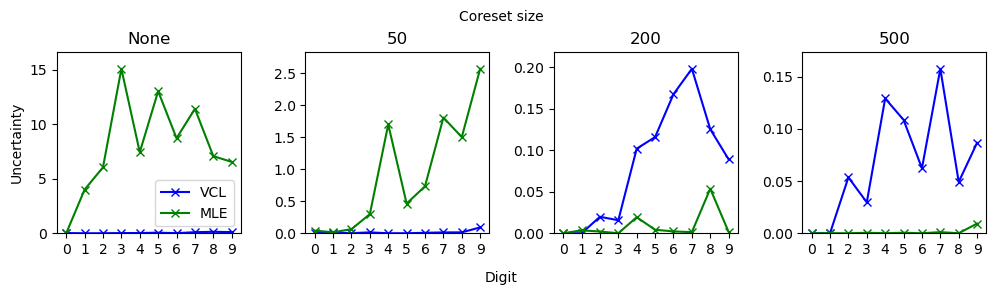

In [60]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for i, coreset in enumerate([0, 50, 200, 500]):
    axs[i].plot(list(range(10)), all_uncertainties_vcl[coreset], '-x', label='VCL', color='blue')
    axs[i].plot(list(range(10)), all_uncertainties_mle[coreset], '-x', label='MLE', color='green')
    max_val = max(max(all_uncertainties_vcl[coreset]), max(all_uncertainties_mle[coreset]))
    max_val = 1.1 * max_val
    axs[i].set_xlim(-0.5, 9.5)
    axs[i].set_xticks(list(range(10)))
    axs[i].set_ylim(0, max_val)
    axs[i].set_title('None' if coreset == 0 else f'{coreset}')

fig.text(0.5, 0.08, 'Digit', ha='center', va='center')
fig.text(0.5, .95, 'Coreset size', ha='center', va='center')
# Adjust the spacing between subplots and the bottom of the figure
plt.tight_layout(rect=[0, 0.1, 1, .95])
axs[0].legend()
axs[0].set_ylabel('Uncertainty')
plt.savefig('plots/uncertainty_600.png')

In [49]:
[float(f'1e{j}') for j in range(-6, 2)]

[1e-06, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

In [82]:
from mnist import TensorDataset

all_accuracies_mle = {}
all_uncertainties_mle = {}

for coreset_size in [0, 50, 200, 500]:
    accuracies = []
    uncertainties = []
    for i in range(10):
        with open(f'./data/mle_{coreset_size}/{i}/sampled_dataset.pkl', 'rb') as f:
            dataset1 = CPU_Unpickler(f).load()
        with open(f'./data/mle_{coreset_size}/sampled_datasets/{i}.pkl', 'rb') as f:
            dataset2 = CPU_Unpickler(f).load()

        dataset = merge_datasets([dataset1, dataset2])
        _data = dataset.data
        _targets = dataset.targets

        acc = []
        unc = []
        for j in range(i+1):
            digit_data = _data[_targets == j]
            digit_targets = _targets[_targets == j]
            digit_dataset = TensorDataset(digit_data, digit_targets)

            print(i, len(digit_dataset))
            out = classifier(digit_dataset.data)
            predicted = torch.argmax(out, 1)
            correct = (predicted == digit_dataset.targets).sum().item()
            acc.append(correct / len(digit_dataset))
            uncertainty = uncertainty_fn(out, digit_dataset.targets).item()
            unc.append(uncertainty / len(digit_dataset))

        accuracies.append(acc)
        uncertainties.append(unc)

    all_accuracies_mle[coreset_size] = accuracies
    all_uncertainties_mle[coreset_size] = uncertainties

0 600
1 300
1 300
2 198
2 198
2 198
3 150
3 150
3 150
3 150
4 120
4 120
4 120
4 120
4 120
5 99
5 99
5 99
5 99
5 99
5 99
6 84
6 84
6 84
6 84
6 84
6 84
6 84
7 75
7 75
7 75
7 75
7 75
7 75
7 75
7 75
8 66
8 66
8 66
8 66
8 66
8 66
8 66
8 66
8 66
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
0 600
1 300
1 300
2 198
2 198
2 198
3 150
3 150
3 150
3 150
4 120
4 120
4 120
4 120
4 120
5 99
5 99
5 99
5 99
5 99
5 99
6 84
6 84
6 84
6 84
6 84
6 84
6 84
7 75
7 75
7 75
7 75
7 75
7 75
7 75
7 75
8 66
8 66
8 66
8 66
8 66
8 66
8 66
8 66
8 66
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
0 600
1 300
1 300
2 198
2 198
2 198
3 150
3 150
3 150
3 150
4 120
4 120
4 120
4 120
4 120
5 99
5 99
5 99
5 99
5 99
5 99
6 84
6 84
6 84
6 84
6 84
6 84
6 84
7 75
7 75
7 75
7 75
7 75
7 75
7 75
7 75
8 66
8 66
8 66
8 66
8 66
8 66
8 66
8 66
8 66
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
9 60
0 600
1 300
1 300
2 198
2 198
2 198
3 150
3 150
3 150
3 150
4 120
4 120
4 120
4 120
4 120
5 99
5 99
5 99
5 99
5 99
5 99
6 84
6 84


In [83]:
all_uncertainties_mle[50]

[[0.04144978205362956],
 [1.3113018818936931e-08, 0.030872646967569986],
 [0.000927096740766005, 0.0004181061504465161, 0.1915469699435764],
 [0.1095074208577474,
  0.09497280120849609,
  0.195591189066569,
  0.7963175964355469],
 [5.34735107421875,
  0.7458823521931967,
  1.5476955413818358,
  0.5574704488118489,
  0.29106032053629555],
 [0.4302091887502959,
  0.004372409497848665,
  0.1941269190624507,
  0.4206685923566722,
  0.2689561362218375,
  1.4640003551136365],
 [0.6422492436000279,
  0.29106912158784415,
  1.11253175281343,
  0.7962937127976191,
  0.2972438448951358,
  0.44647661844889325,
  1.5492513747442336],
 [3.647626953125,
  1.0606844075520834,
  1.591404520670573,
  5.246401774088541,
  0.7383809407552083,
  0.2076871871948242,
  1.0733139038085937,
  0.8814801025390625],
 [2.4964761445016572,
  0.24571450551350912,
  3.449216669256037,
  3.311782374526515,
  1.1452052954471472,
  0.7411604794588956,
  0.24512406551476681,
  0.0003387755291028456,
  1.8695657903497869

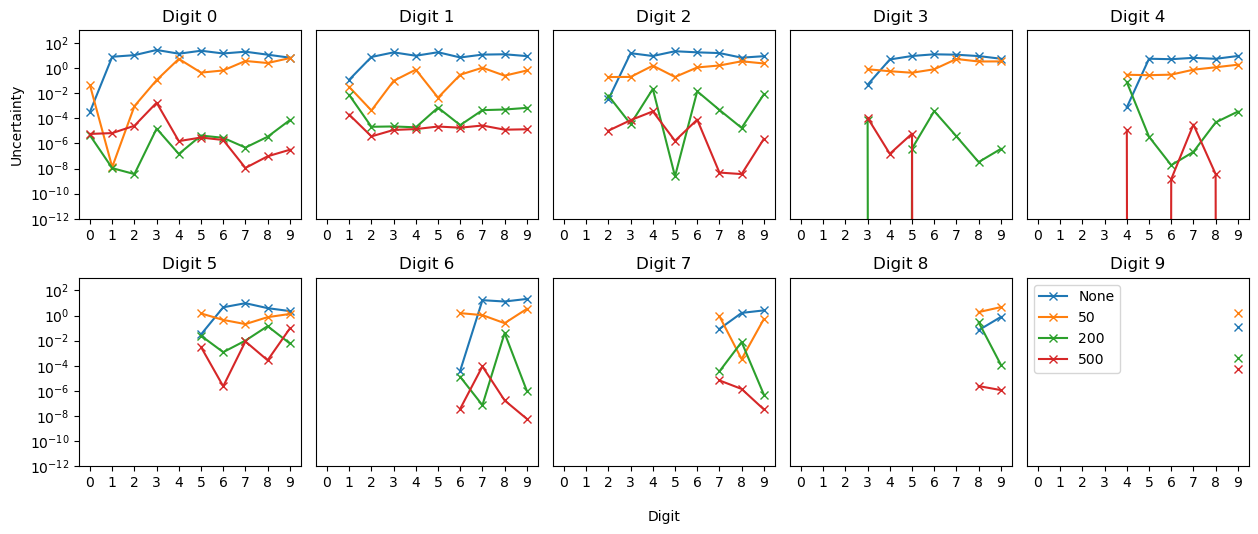

In [94]:
all_uncertainties_plot = all_uncertainties_vcl[0]

fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(12, 6))
for i in range(10):
    for j in [0, 50, 200, 500]:
        uncertainties = all_uncertainties_mle[j]
        uncertainties = [uncertainties[k][i] for k in range(i,10)]
        axs[i//5, i%5].plot(list(range(i,10)), uncertainties, '-x', label=('None' if j == 0 else f'{j}'))

    axs[i//5, i%5].set_xlim(-0.5, 9.5)
    axs[i//5, i%5].set_xticks(list(range(10)))
    axs[i//5, i%5].set_title(f'Digit {i}')
    axs[i//5, i%5].set_yscale('log')
    axs[i//5, i%5].set_ylim(1e-12, 1e3)
    axs[i//5, i%5].set_yticks([])

fig.text(0.5, 0.08, 'Digit', ha='center', va='center')
# Adjust the spacing between subplots and the bottom of the figure
plt.tight_layout(rect=[0, 0.1, 1, .95])
axs[1, 4].legend()
axs[0, 0].set_ylabel('Uncertainty')
axs[0, 0].set_yticks([float(f'1e{j}') for j in range(-12, 3, 2)])
axs[1, 0].set_yticks([float(f'1e{j}') for j in range(-12, 3, 2)])
# plt.savefig('plots/uncertainty_600.png')

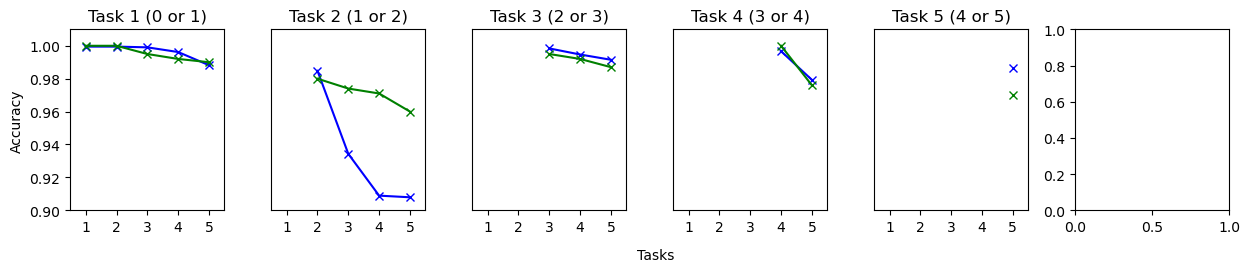

In [97]:
jax_res = [[0.9995, 0.9995, 0.99905, 0.9962, 0.9882], [0.9848, 0.9343, 0.9089, 0.9079], [0.9984, 0.9947, 0.9915], [0.9967, 0.9793], [0.9864]]
tf_res = [[1.00, 1.00, 0.995, 0.992, 0.99], [0.98, 0.974, 0.971, 0.96], [0.995, 0.992, 0.987], [1.00, 0.976], [0.97]]

fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(12, 3))
for i in range(5):
    jax_res_i = jax_res[i]
    tf_res_i = tf_res[i]
    axs[i].plot(list(range(i+1,6)), jax_res_i, '-x', label='JAX', color='blue')
    axs[i].plot(list(range(i+1,6)), tf_res_i, '-x', label='TF', color='green')

    axs[i].set_xlim(0.5, 5.5)
    axs[i].set_xticks(list(range(1,6)))
    axs[i].set_title(f'Task {i+1} ({i} or {i+1})')
    axs[i].set_ylim(.9, 1.01)
    axs[i].set_yticks([])

average_jax = [sum(jax_res[i]) / len(jax_res[i]) for i in range(5)]
average_tf = [sum(tf_res[i]) / len(tf_res[i]) for i in range(5)]
axs[5].plot(list(range(1,6)), average_jax, '-x', label='JAX', color='blue')
axs[5].plot(list(range(1,6)), average_tf, '-x', label='TF', color='green')
axs[5].set_xlim(0.5, 5.5)
axs[5].set_xticks(list(range(1,6)))
axs[5].set_title('Average')
axs[5].set_ylim(.9, 1.01)
axs[5].set_yticks([])


fig.text(0.5, 0.08, 'Tasks', ha='center', va='center')
# Adjust the spacing between subplots and the bottom of the figure
plt.tight_layout(rect=[0, 0.1, 1, .95])
axs[0].set_ylabel('Accuracy')
axs[0].set_yticks([i /100 for i in range(90, 101, 2)])